# Explore the Benefits of Rebalancing

In this exercise, we are going to explore the benefits of synthetic rebalancing of heavily imbalanced datasets, where a minority class of interest accounts for less than 0.1% of cases. 

Rebalancing can be useful for cases where we want to learn more of an otherwise small or underrepresented population segment by seeing more examples thereof. Of course, also a synthesizer can only leverage the data that it has seen. But if the method is data-efficient, and in particular more effective than the downstream data consumer, then it is possible to gain a significant advantage by synthetic rebalancing.

<img src='./rebalancing.png' width="600px"/>

In terms of evaluation, we again turn towards the Train-Synthetic-Test-Real approach to benchmark the predictive accuracy of a model that is trained on the (rebalanced) synthetic data, and compare that to a model trained on the (imbalanced) actual data. In addition, we will also benchmark against established methods for rebalancing, like naive upsampling as well as SMOTE. All four models are then evaluated on a holdout data, and compared in terms of predictive performance.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using again the UCI Adult Income [[1](#refs)] dataset, as well as the same training and validation split, that was used in the Train-Synthetic-Test-Real tutorial. However, we did create an artificial imbalance of 0.1% of low-income records in the training data, by downsampling the minority class. The corresponding preparation script can be found at the end of this notebook.

1. Download `census-training-imbalanced.csv` from [here](./census-training-imbalanced.csv).

2. Synthesize `census-training-imbalanced.csv` via [MOSTLY AI](https://mostly.ai/), configure column `income` as `categorical`, and rebalance it by setting the probability for value `>50K` to 50%. Save the column settings, and then launch the job.

<img src='./screen1.png' width="600px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer.

4. Upload the generated synthetic data to this Notebook via executing the next cell.

In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-synthetic-balanced.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 29,753 records and 15 attributes


## Analyze Balanced Data

In [2]:
trn = pd.read_csv('census-training-imbalanced.csv')
trn_min = trn.loc[trn['income']=='>50K']
trn_ratio = trn_min.shape[0] / trn.shape[0]
syn_min = syn.loc[syn['income']=='>50K']
syn_ratio = syn_min.shape[0] / syn.shape[0]
print(f'The imbalanced training dataset contains {trn_min.shape[0]:,} minority samples (={trn_ratio:.1%}) ')
print(f'The balanced synthetic dataset contains {syn_min.shape[0]:,} minority samples (={syn_ratio:.1%}) ')

The imbalanced training dataset contains 29 minority samples (=0.1%) 
The balanced synthetic dataset contains 14,796 minority samples (=49.7%) 


In [3]:
trn_fem_profs = trn_min[(trn_min.sex=='Female') & (trn_min.education=='Prof-school')]
syn_fem_profs = syn_min[(syn_min.sex=='Female') & (syn_min.education=='Prof-school')]
print(f'The imbalanced training dataset contains {trn_fem_profs.shape[0]:,} female professors with high income')
print(f'The balanced synthetic dataset contains {syn_fem_profs.shape[0]:,} female professors with high income')

The imbalanced training dataset contains 0 female professors with high income
The balanced synthetic dataset contains 64 female professors with high income


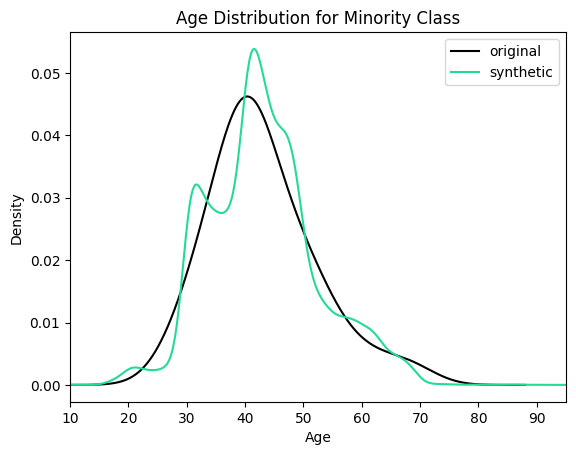

In [4]:
import matplotlib.pyplot as plt
plt.xlim(10, 95)
plt.title('Age Distribution for Minority Class')
plt.xlabel('Age')
trn_min.age.plot.kde(color='black')
syn_min.age.plot.kde(color='#24db96')
plt.legend({'original': 'black', 'synthetic': '#24db96'})
plt.show()

## Compare Model Performance

In [5]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

target_col = 'income'
target_val = '>50K'

# prepare data, and split into features `X` and target `y`
def prepare_xy(df: pd.DataFrame):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

# train ML model with early stopping
def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        num_boost_round=200,
        params={
            'is_unbalance': True, # Note, that we help LightGBM understand this is unbalanced
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

# apply ML Model to some holdout data, report key metrics, and visualize scores
def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    f1 = f1_score(y_hol, probs>0.5, average='macro')
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name='target').reset_index(drop=True)
    ], axis=1)
    fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, palette=['#008CFB', '#FF004F'])
    fig = plt.title(f"AUC: {auc:.3f}, F1 Score: {f1:.2f}", fontsize = 20)
    plt.show()
    return auc

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_hol = pd.read_csv('census-holdout.csv')
df_hol_min = df_hol.loc[df_hol['income']=='>50K']
print(f"Holdout data consists of {df_hol.shape[0]:,} records",
      f"with {df_hol_min.shape[0]:,} samples from the minority class")

Holdout data consists of 9,768 records with 2,337 samples from the minority class


### Train model on imbalanced training data

In [7]:
%%capture
X_trn, y_trn = prepare_xy(trn)
model_trn = train_model(X_trn, y_trn)

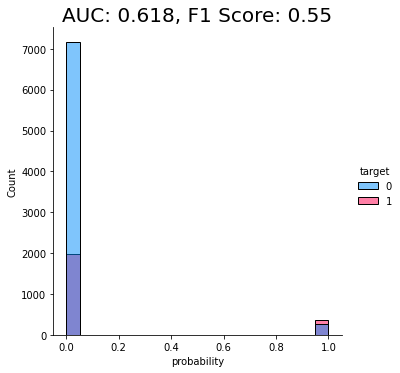

In [8]:
auc_trn = evaluate_model(model_trn, df_hol)

With an AUC of about 60%, the model trained on the imbalanced dataset is just a bit better in distinguishing between actual low and high income classes than a random guess. I.e., the downstream LightGBM model is not able to learn much signal due to the low number of samples.

### Train model on naively rebalanced training data

In [9]:
%%capture
from imblearn.over_sampling import RandomOverSampler
X_trn, y_trn = prepare_xy(trn)
sm = RandomOverSampler(random_state=1)
X_trn_up, y_trn_up = sm.fit_resample(X_trn, y_trn)
model_trn_up = train_model(X_trn_up, y_trn_up)

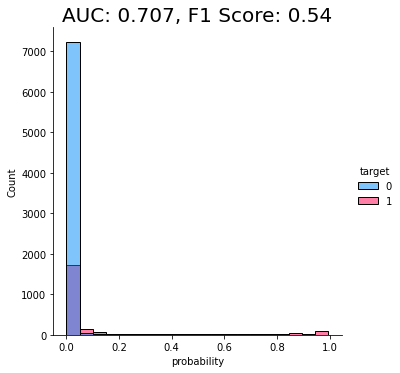

In [10]:
auc_trn_up = evaluate_model(model_trn_up, df_hol)

Random "naive" upsampling [[2](#refs)], which simply adds minority samples multiple times to achieve a balance, only marginally helps the downstream model in this case.

### Train model on SMOTE rebalanced training data

In [11]:
%%capture
from imblearn.over_sampling import SMOTENC
X_trn, y_trn = prepare_xy(trn)
sm = SMOTENC(categorical_features=X_trn.dtypes=='category', random_state=1)
X_trn_smote, y_trn_smote = sm.fit_resample(X_trn, y_trn)
model_trn_smote = train_model(X_trn_smote, y_trn_smote)

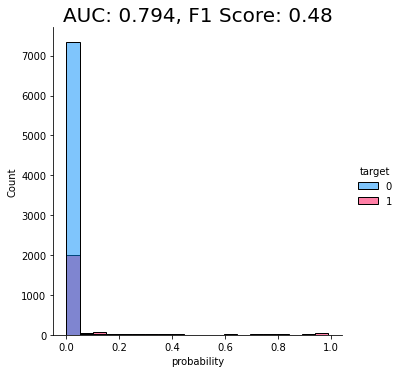

In [12]:
auc_trn_smote = evaluate_model(model_trn_smote, df_hol)

SMOTE upsampling [[3](#refs)], which creates novel (non-privacy-preserving) samples by interpolating between neighboring samples, does boost the performance of the downstream model to close to 80%.

### Train model on balanced synthetic data

In [13]:
%%capture
X_syn, y_syn = prepare_xy(syn)
model_syn = train_model(X_syn, y_syn)

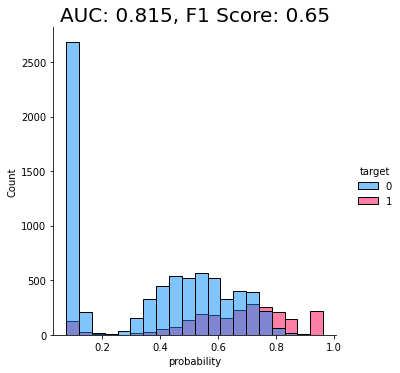

In [14]:
auc_syn = evaluate_model(model_syn, df_hol)

With an AUC of about 80%, the model trained on the synthetic balanced dataset is significantly better in distinguishing between actual low and high income classes than the same model that was trained on the imbalanced original data. It also outperforms in this case the models trained on data, that has been upsampled randomly or via SMOTE.

Also note, that the macro-average F1-score, which balances precision and recall, also yields the best performance for training on rebalanced synthetic data.

This is a strong proof of value of synthetic rebalancing for learning more about a small sub-group within the population.

## Conclusion

For the given dataset and the given synthesizer we can see a significant boost in ML performance, if we train on a balanced synthetic dataset rather than on the imbalanced original dataset. The actual lift in performance may vary, depending on the dataset, the predictive task, and the chosen ML model.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to repeat the experiments for different class imbalances
* to repeat the experiments for different datasets, ML models, etc.

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html

## Extras - Data Preparation

The following code snippet can be used to create an artificially imbalanced training dataset.

In [15]:
def create_imbalance(df, target, ratio):
    val_min, val_maj = df[target].value_counts().sort_values().index
    df_maj = df.loc[df[target]==val_maj]
    n_min = int(df_maj.shape[0]/(1-ratio)*ratio)
    df_min = df.loc[df[target]==val_min].sample(n=n_min, random_state=1)
    df_maj = df.loc[df[target]==val_maj]
    df_imb = pd.concat([df_min, df_maj]).sample(frac=1, random_state=1)
    return df_imb

df_trn = pd.read_csv('census-training.csv')
df_trn_imb = create_imbalance(df_trn, 'income', 1/1000)
df_trn_imb.to_csv('census-training-imbalanced.csv', index=False)